In [62]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import make_scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse,greater_is_better=False)

# Load the data.
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

data_description.txt
sample_submission.csv
test.csv
train.csv



(array([ 148.,  723.,  373.,  135.,   51.,   19.,    4.,    3.,    2.,    2.]),
 array([  34900.,  106910.,  178920.,  250930.,  322940.,  394950.,
         466960.,  538970.,  610980.,  682990.,  755000.]),
 <a list of 10 Patch objects>)

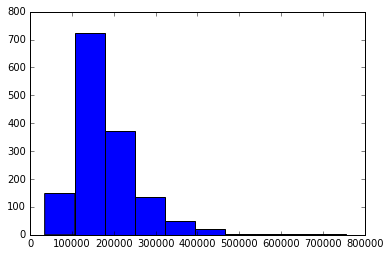

In [28]:
plt.hist(train_df.SalePrice)

In [3]:
# There are a few houses with more than 4000 sq ft living area that are
# outliers, so we drop them from the training data. (There is also one in
# the test set but we obviously can't drop that one.)
train_df.drop(train_df[train_df["GrLivArea"] > 4000].index, inplace=True)

# The test example with ID 666 has GarageArea, GarageCars, and GarageType 
# but none of the other fields, so use the mode and median to fill them in.
test_df.loc[666, "GarageQual"] = "TA"
test_df.loc[666, "GarageCond"] = "TA"
test_df.loc[666, "GarageFinish"] = "Unf"
test_df.loc[666, "GarageYrBlt"] = "1980"

# The test example 1116 only has GarageType but no other information. We'll 
# assume it does not have a garage.
test_df.loc[1116, "GarageType"] = np.nan

# For imputing missing values: fill in missing LotFrontage values by the median
# LotFrontage of the neighborhood.
lot_frontage_by_neighborhood = train_df["LotFrontage"].groupby(train_df["Neighborhood"])

# Used to convert categorical features into ordinal numbers.
# (There's probably an easier way to do this, but it works.)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

# Combine all the (numerical) features into one big DataFrame. We don't add 
# the one-hot encoded variables here yet, that happens later on.
def munge(df):
    all_df = pd.DataFrame(index = df.index)
   
    all_df["LotFrontage"] = df["LotFrontage"]   
    for key, group in lot_frontage_by_neighborhood:
        idx = (df["Neighborhood"] == key) & (df["LotFrontage"].isnull())
        all_df.loc[idx, "LotFrontage"] = group.median()    

    all_df["LotArea"] = df["LotArea"]

    all_df["MasVnrArea"] = df["MasVnrArea"]
    all_df["MasVnrArea"].fillna(0, inplace=True)
   
    all_df["BsmtFinSF1"] = df["BsmtFinSF1"]
    all_df["BsmtFinSF1"].fillna(0, inplace=True)

    all_df["BsmtFinSF2"] = df["BsmtFinSF2"]
    all_df["BsmtFinSF2"].fillna(0, inplace=True)

    all_df["BsmtUnfSF"] = df["BsmtUnfSF"]
    all_df["BsmtUnfSF"].fillna(0, inplace=True)

    all_df["TotalBsmtSF"] = df["TotalBsmtSF"]
    all_df["TotalBsmtSF"].fillna(0, inplace=True)

    all_df["1stFlrSF"] = df["1stFlrSF"]
    all_df["2ndFlrSF"] = df["2ndFlrSF"]
    all_df["GrLivArea"] = df["GrLivArea"]
    
    all_df["GarageArea"] = df["GarageArea"]
    all_df["GarageArea"].fillna(0, inplace=True)

    all_df["WoodDeckSF"] = df["WoodDeckSF"]
    all_df["OpenPorchSF"] = df["OpenPorchSF"]
    all_df["EnclosedPorch"] = df["EnclosedPorch"]
    all_df["3SsnPorch"] = df["3SsnPorch"]
    all_df["ScreenPorch"] = df["ScreenPorch"]
    
    all_df["BsmtFullBath"] = df["BsmtFullBath"]
    all_df["BsmtFullBath"].fillna(0, inplace=True)

    all_df["BsmtHalfBath"] = df["BsmtHalfBath"]
    all_df["BsmtHalfBath"].fillna(0, inplace=True)

    all_df["FullBath"] = df["FullBath"] 
    all_df["HalfBath"] = df["HalfBath"] 
    all_df["BedroomAbvGr"] = df["BedroomAbvGr"] 
    all_df["KitchenAbvGr"] = df["KitchenAbvGr"] 
    all_df["TotRmsAbvGrd"] = df["TotRmsAbvGrd"] 
    all_df["Fireplaces"] = df["Fireplaces"] 

    all_df["GarageCars"] = df["GarageCars"]
    all_df["GarageCars"].fillna(0, inplace=True)

    all_df["CentralAir"] = (df["CentralAir"] == "Y") * 1.0
   
    all_df["OverallQual"] = df["OverallQual"]
    all_df["OverallCond"] = df["OverallCond"]

    # Quality measurements are stored as text but we can convert them to 
    # numbers where a higher number means higher quality.

    qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    all_df["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)
    all_df["ExterCond"] = df["ExterCond"].map(qual_dict).astype(int)
    all_df["BsmtQual"] = df["BsmtQual"].map(qual_dict).astype(int)
    all_df["BsmtCond"] = df["BsmtCond"].map(qual_dict).astype(int)
    all_df["HeatingQC"] = df["HeatingQC"].map(qual_dict).astype(int)
    all_df["KitchenQual"] = df["KitchenQual"].map(qual_dict).astype(int)
    all_df["FireplaceQu"] = df["FireplaceQu"].map(qual_dict).astype(int)
    all_df["GarageQual"] = df["GarageQual"].map(qual_dict).astype(int)
    all_df["GarageCond"] = df["GarageCond"].map(qual_dict).astype(int)

    all_df["BsmtExposure"] = df["BsmtExposure"].map(
        {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

    bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    all_df["BsmtFinType1"] = df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    all_df["BsmtFinType2"] = df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

    all_df["Functional"] = df["Functional"].map(
        {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

    all_df["GarageFinish"] = df["GarageFinish"].map(
        {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

    all_df["Fence"] = df["Fence"].map(
        {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    all_df["YearBuilt"] = df["YearBuilt"]
    all_df["YearRemodAdd"] = df["YearRemodAdd"]

    all_df["GarageYrBlt"] = df["GarageYrBlt"]
    all_df["GarageYrBlt"].fillna(0.0, inplace=True)

    all_df["MoSold"] = df["MoSold"]
    all_df["YrSold"] = df["YrSold"]
    
    all_df["LowQualFinSF"] = df["LowQualFinSF"]
    all_df["MiscVal"] = df["MiscVal"]

    all_df["PoolQC"] = df["PoolQC"].map(qual_dict).astype(int)

    all_df["PoolArea"] = df["PoolArea"]
    all_df["PoolArea"].fillna(0, inplace=True)
    
    # Add categorical features as numbers too. It seems to help a bit.
    all_df = factorize(df, all_df, "MSSubClass")
    all_df = factorize(df, all_df, "MSZoning", "RL")
    all_df = factorize(df, all_df, "LotConfig")
    all_df = factorize(df, all_df, "Neighborhood")
    all_df = factorize(df, all_df, "Condition1")
    all_df = factorize(df, all_df, "BldgType")
    all_df = factorize(df, all_df, "HouseStyle")
    all_df = factorize(df, all_df, "RoofStyle")
    all_df = factorize(df, all_df, "Exterior1st", "Other")
    all_df = factorize(df, all_df, "Exterior2nd", "Other")
    all_df = factorize(df, all_df, "MasVnrType", "None")
    all_df = factorize(df, all_df, "Foundation")
    all_df = factorize(df, all_df, "SaleType", "Oth")
    all_df = factorize(df, all_df, "SaleCondition")

    # IR2 and IR3 don't appear that often, so just make a distinction
    # between regular and irregular.
    all_df["IsRegularLotShape"] = (df["LotShape"] == "Reg") * 1

    # Most properties are level; bin the other possibilities together
    # as "not level".
    all_df["IsLandLevel"] = (df["LandContour"] == "Lvl") * 1

    # Most land slopes are gentle; treat the others as "not gentle".
    all_df["IsLandSlopeGentle"] = (df["LandSlope"] == "Gtl") * 1

    # Most properties use standard circuit breakers.
    all_df["IsElectricalSBrkr"] = (df["Electrical"] == "SBrkr") * 1

    # About 2/3rd have an attached garage.
    all_df["IsGarageDetached"] = (df["GarageType"] == "Detchd") * 1

    # Most have a paved drive. Treat dirt/gravel and partial pavement
    # as "not paved".
    all_df["IsPavedDrive"] = (df["PavedDrive"] == "Y") * 1

    # The only interesting "misc. feature" is the presence of a shed.
    all_df["HasShed"] = (df["MiscFeature"] == "Shed") * 1.  

    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    all_df["Remodeled"] = (all_df["YearRemodAdd"] != all_df["YearBuilt"]) * 1
    
    # Did a remodeling happen in the year the house was sold?
    all_df["RecentRemodel"] = (all_df["YearRemodAdd"] == all_df["YrSold"]) * 1
    
    # Was this house sold in the year it was built?
    all_df["VeryNewHouse"] = (all_df["YearBuilt"] == all_df["YrSold"]) * 1

    all_df["Has2ndFloor"] = (all_df["2ndFlrSF"] == 0) * 1
    all_df["HasMasVnr"] = (all_df["MasVnrArea"] == 0) * 1
    all_df["HasWoodDeck"] = (all_df["WoodDeckSF"] == 0) * 1
    all_df["HasOpenPorch"] = (all_df["OpenPorchSF"] == 0) * 1
    all_df["HasEnclosedPorch"] = (all_df["EnclosedPorch"] == 0) * 1
    all_df["Has3SsnPorch"] = (all_df["3SsnPorch"] == 0) * 1
    all_df["HasScreenPorch"] = (all_df["ScreenPorch"] == 0) * 1

    # These features actually lower the score a little.
    # all_df["HasBasement"] = df["BsmtQual"].isnull() * 1
    # all_df["HasGarage"] = df["GarageQual"].isnull() * 1
    # all_df["HasFireplace"] = df["FireplaceQu"].isnull() * 1
    # all_df["HasFence"] = df["Fence"].isnull() * 1

    # Months with the largest number of deals may be significant.
    all_df["HighSeason"] = df["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    all_df["NewerDwelling"] = df["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
    all_df.loc[df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
    all_df["Neighborhood_Good"].fillna(0, inplace=True)

    all_df["SaleCondition_PriceDown"] = df.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # House completed before sale or not
    all_df["BoughtOffPlan"] = df.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    all_df["BadHeating"] = df.HeatingQC.replace(
        {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    all_df["TotalArea"] = all_df[area_cols].sum(axis=1)

    all_df["TotalArea1st2nd"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"]

    all_df["Age"] = 2010 - all_df["YearBuilt"]
    all_df["TimeSinceSold"] = 2010 - all_df["YrSold"]

    all_df["SeasonSold"] = all_df["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    all_df["YearsSinceRemodel"] = all_df["YrSold"] - all_df["YearRemodAdd"]
    
    # Simplifications of existing features into bad/average/good.
    all_df["SimplOverallQual"] = all_df.OverallQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplOverallCond"] = all_df.OverallCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplPoolQC"] = all_df.PoolQC.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    all_df["SimplGarageCond"] = all_df.GarageCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplGarageQual"] = all_df.GarageQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFunctional"] = all_df.Functional.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    all_df["SimplKitchenQual"] = all_df.KitchenQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplHeatingQC"] = all_df.HeatingQC.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtFinType1"] = all_df.BsmtFinType1.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtFinType2"] = all_df.BsmtFinType2.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtCond"] = all_df.BsmtCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtQual"] = all_df.BsmtQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterCond"] = all_df.ExterCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterQual"] = all_df.ExterQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
            
    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    all_df["NeighborhoodBin"] = df["Neighborhood"].map(neighborhood_map)
    return all_df

train_df_munged = munge(train_df)
test_df_munged = munge(test_df)

print(train_df_munged.shape)
print(test_df_munged.shape)

# Copy NeighborhoodBin into a temporary DataFrame because we want to use the
# unscaled version later on (to one-hot encode it). 
neighborhood_bin_train = pd.DataFrame(index = train_df.index)
neighborhood_bin_train["NeighborhoodBin"] = train_df_munged["NeighborhoodBin"]
neighborhood_bin_test = pd.DataFrame(index = test_df.index)
neighborhood_bin_test["NeighborhoodBin"] = test_df_munged["NeighborhoodBin"]

################################################################################

numeric_features = train_df_munged.dtypes[train_df_munged.dtypes != "object"].index

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = train_df_munged[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

train_df_munged[skewed] = np.log1p(train_df_munged[skewed])
test_df_munged[skewed] = np.log1p(test_df_munged[skewed])

# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df_munged[numeric_features])

scaled = scaler.transform(train_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    train_df_munged[col] = scaled[:, i]

scaled = scaler.transform(test_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    test_df_munged[col] = scaled[:, i]

################################################################################

# Convert categorical features using one-hot encoding.
def onehot(onehot_df, df, column_name, fill_na, drop_name):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix="_" + column_name)
    
    # Dropping one of the columns actually made the results slightly worse.
    # if drop_name is not None:
    #     dummies.drop(["_" + column_name + "_" + drop_name], axis=1, inplace=True)

    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

def munge_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, "MSSubClass", None, "40")
    onehot_df = onehot(onehot_df, df, "MSZoning", "RL", "RH")
    onehot_df = onehot(onehot_df, df, "LotConfig", None, "FR3")
    onehot_df = onehot(onehot_df, df, "Neighborhood", None, "OldTown")
    onehot_df = onehot(onehot_df, df, "Condition1", None, "RRNe")
    onehot_df = onehot(onehot_df, df, "BldgType", None, "2fmCon")
    onehot_df = onehot(onehot_df, df, "HouseStyle", None, "1.5Unf")
    onehot_df = onehot(onehot_df, df, "RoofStyle", None, "Shed")
    onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Foundation", None, "Wood")
    onehot_df = onehot(onehot_df, df, "SaleType", "WD", "Oth")
    onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal", "AdjLand")

    # Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    onehot_df = onehot(onehot_df, temp_df, "MasVnrType", "None", "BrkCmn")

    # Also add the booleans from calc_df as dummy variables.
    onehot_df = onehot(onehot_df, df, "LotShape", None, "IR3")
    onehot_df = onehot(onehot_df, df, "LandContour", None, "Low")
    onehot_df = onehot(onehot_df, df, "LandSlope", None, "Sev")
    onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr", "FuseP")
    onehot_df = onehot(onehot_df, df, "GarageType", "None", "CarPort")
    onehot_df = onehot(onehot_df, df, "PavedDrive", None, "P")
    onehot_df = onehot(onehot_df, df, "MiscFeature", "None", "Othr")

    # Features we can probably ignore (but want to include anyway to see
    # if they make any positive difference).
    # Definitely ignoring Utilities: all records are "AllPub", except for
    # one "NoSeWa" in the train set and 2 NA in the test set.
    onehot_df = onehot(onehot_df, df, "Street", None, "Grvl")
    onehot_df = onehot(onehot_df, df, "Alley", "None", "Grvl")
    onehot_df = onehot(onehot_df, df, "Condition2", None, "PosA")
    onehot_df = onehot(onehot_df, df, "RoofMatl", None, "WdShake")
    onehot_df = onehot(onehot_df, df, "Heating", None, "Wall")

    # I have these as numerical variables too.
    onehot_df = onehot(onehot_df, df, "ExterQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "ExterCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "HeatingQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "KitchenQual", "TA", "Ex")
    onehot_df = onehot(onehot_df, df, "FireplaceQu", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "PoolQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtExposure", "None", "Gd")
    onehot_df = onehot(onehot_df, df, "BsmtFinType1", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "BsmtFinType2", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "Functional", "Typ", "Typ")
    onehot_df = onehot(onehot_df, df, "GarageFinish", "None", "Fin")
    onehot_df = onehot(onehot_df, df, "Fence", "None", "MnPrv")
    onehot_df = onehot(onehot_df, df, "MoSold", None, None)
    
    # Divide up the years between 1871 and 2010 in slices of 20 years.
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)

    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)
    
    onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None, None)

    return onehot_df

# Add the one-hot encoded categorical features.
onehot_df = munge_onehot(train_df)
onehot_df = onehot(onehot_df, neighborhood_bin_train, "NeighborhoodBin", None, None)
train_df_munged = train_df_munged.join(onehot_df)

# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
train_df_munged.drop(drop_cols, axis=1, inplace=True)

onehot_df = munge_onehot(test_df)
onehot_df = onehot(onehot_df, neighborhood_bin_test, "NeighborhoodBin", None, None)
test_df_munged = test_df_munged.join(onehot_df)

# This column is missing in the training data. There is only one example with
# this value in the test set. So just drop it.
test_df_munged.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns. They are either not very helpful or they cause overfitting.
drop_cols = [
    "_Condition2_PosN",    # only two are not zero
    "_MSZoning_C (all)",
    "_MSSubClass_160",
]
train_df_munged.drop(drop_cols, axis=1, inplace=True)
test_df_munged.drop(drop_cols, axis=1, inplace=True)

################################################################################

# We take the log here because the error metric is between the log of the
# SalePrice and the log of the predicted price. That does mean we need to 
# exp() the prediction to get an actual sale price.
label_df = pd.DataFrame(index = train_df_munged.index, columns=["SalePrice"])
label_df["SalePrice"] = np.log(train_df["SalePrice"])

print("Training set size:", train_df_munged.shape)
print("Test set size:", test_df_munged.shape)

################################################################################

(1456, 111)
(1459, 111)
('Training set size:', (1456, 403))
('Test set size:', (1459, 403))


1456


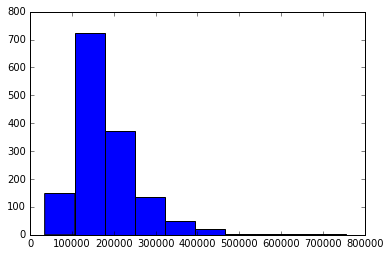

In [31]:
plt.hist(train_df.SalePrice)
print sum(np.exp(label_df.SalePrice)<400000)
#train_df_munged_trimed = train_df_munged[label_df.SalePrice<650000]

In [35]:
# XGBoost -- I did some "manual" cross-validation here but should really find
# these hyperparameters using CV. ;-)

import xgboost as xgb

params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 0,
    'subsample': 0.8,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 11,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
    'reg_alpha':0.9,
    'reg_lambda':0.6,
    'seed':42,
    'verbose_eval': 1
    
}

bst_cv = xgb.cv(params=params,dtrain=xgb.DMatrix(data=train_df_munged,label=label_df),
                nfold=10,num_boost_round=10000,early_stopping_rounds=120)

In [63]:
class CustomXgbRegressor(object):
    def __init__(self,**kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent':0,'seed':1234,'objective':'reg:linear'})
    
    def fit(self,X,y):
        dtrain = xgb.DMatrix(X,y)
        self.bst = xgb.train(params = self.params,num_boost_round = self.num_boost_round,dtrain = dtrain)

    def predict(self,X):
        dtest = xgb.DMatrix(X)
        return(self.bst.predict(dtest))
    
    def kfold(self,X,y,num_boost_round=1000,nfold=5,early_stopping_rounds = 120):
        dtrain = xgb.DMatrix(X,y)
        self.cv = xgb.cv(params = self.params,dtrain = dtrain,nfold=nfold, early_stopping_rounds = early_stopping_rounds,
                        num_boost_round = num_boost_round)
    
    def plot_feat_importance(self):
        feature_importance = pd.Series(self.bst.get_fscore()).sort_values(ascending = False)
        feature_importance.plot(title = 'feature importance plot')
        plt.ylabel = 'feature importance score'
    
    def get_params(self,deep=True):
        return self.params
    
    def set_params(self,**params):
        self.params.update(params)
        return self
        

In [ ]:
xgb_param_grid = {'max_depth':range(4,17),
                  'min_child_weight':range(1,4),
                  'subsample':[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                  'colsample_by_tree':[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                  'reg_alpha':[0.01,0.1,1,10]}
grid = GridSearchCV(CustomXgbRegressor(eta = 0.1, num_boost_round = 1000, early_stopping_rounds = 20, colsample_by_tree = 0.7,subsample = 0.7),
                    cv = 5,param_grid=xgb_param_grid, scoring = rmse_scorer)
grid.fit(train_df_munged,label_df)

In [ ]:
grid.grid_scores_ , grid.best_params_, grid.best_score_

In [34]:
np.argmin(bst_cv['test-rmse-mean'])

3348

In [21]:
regr = xgb.train(params = params, num_boost_round= 579,
                 dtrain=xgb.DMatrix(data=train_df_munged,label=label_df))

#regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(xgb.DMatrix(train_df_munged))
y_test = label_df
print("XGBoost score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(xgb.DMatrix(test_df_munged))

('XGBoost score on training set: ', 0.051339672147556123)


In [22]:
################################################################################

from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train_df_munged)
y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_lasso = regr.predict(test_df_munged)

('Lasso score on training set: ', 0.10155983007006425)


In [23]:
################################################################################

# Blend the results of the two regressors and save the prediction to a CSV file.

y_pred = (y_pred_xgb + y_pred_lasso) / 2
y_pred = np.exp(y_pred)

pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('avg_xgb_lasso_try1.csv', header=True, index_label='Id')